# Writing Parallel Code (Manodeep Sinha, Harley-Wood School, July 2020)

The goal for this session is to introduce you to the distributed programming paradigm. We will discuss the differences between writing sequential (or serial) code and parallel code, and work on an example parallel python code (using mpi4py). The key idea in this talk is to understand how to partition work into independent units and then use `mpi4py` to run the jobs in parallel.

Attendee pre-requesites:
- Familiar with good coding practices (see talks by Rebecca, Paul at this HWSA or HWSA 2019)
- Familiar with python programming

Software pre-requisites:
- python3.6+
- numpy
- mpi4py


## Why you might want to write parallel code

Python, by design, only runs in a sequential mode. While there are way to run multi-threaded using `C` or `cython`, python code is sequential in general. Being able to run a job in parallel reduces the total time taken, which means you get to your Science results quicker. 

One way of parallelising code is through the `multiprocessing` package; however, that only runs on a single computer and is limited by the total number of available cores on that computer (almost certainly less 100 cores per computer). Running a job in a distributed fashion (e.g., MPI parallel) let's you scale to 100's-1000's of cores. 

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'xtick.direction': 'in'})
matplotlib.rcParams.update({'ytick.direction': 'in'})
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Let's look at some processing code

Here we will count the number of lines in each file from a list of ascii files. 

In [3]:
def count_lines_in_filenames(filenames):
    """
    Returns a list containing the number of lines in the 
    input (ascii) files   
    """
    
    def _count_lines(fname):
        with open(fname, 'rt') as f:
            count = 0
            for line in f:
                count += 1
        return count
        
    # Protect against the case where a single
    # file was passsed
    if not isinstance(filenames, (list, tuple)):
        filenames = [filenames]
        
    numlines = []
    for fname in filenames:
        numlines.append(_count_lines(fname))

    # or use list-comprehension
    # numlines = [_count_lines(fname) for fname in filenames]

    return numlines

### But what if you want to count lines a different way

Easy enough - just add a second parameter that accepts a function. If this parameter is unspecified, then the internal `_count_lines` function will be used.

In [4]:
def count_lines_in_filenames_external_func(filenames, line_counter_func=None):
    def _count_lines(fname):
        with open(fname, 'rt') as f:
            count = 0
            for line in f:
                count += 1
        return count
    
    if not line_counter_func:        
        line_counter_func = _count_lines
    
    # Protect against the case where a single
    # file was passsed
    if not isinstance(filenames, (list, tuple)):
        filenames = [filenames]

    numlines = []
    for fname in filenames:
        numlines.append(line_counter_func(fname))

    # or use list comprehension
    # numlines = [line_counter_func(fname) for fname in filenames]

    return numlines

### But line-counting is simple, how about an arbitrary function?

So far we have used the simple example of counting lines, but you can easily extend to concept to any arbitrary processing of a file. If no external processing function is passed, then we will use the "line-counting" function.

In [5]:
def arbitrary_processing(filenames, processing_func=None):
    def _count_lines(fname):
        with open(fname, 'rt') as f:
            count = 0
            for line in f:
                count += 1
        return count

    if not processing_func:        
        processing_func = _count_lines
    
    # Protect against the case where a single
    # file was passsed
    if not isinstance(filenames, (list, tuple)):
        files = [filenames]
        
    results = []
    for fname in filenames:
        results.append(processing_func(fname))

    # or use list comprehension
    # results = [processing_func(fname) for fname in filenames]        

    return results

<hr style="border:2px solid gray"> </hr>

# Basic Concepts of Distributed Computing


* What information is shared
* Which instruction runs when
* Which task does what
* Where is the output produced


<hr style="border:2px solid gray"> </hr>


## What information is shared

While programming, we are always working with variables. Generally speaking there are three kinds of variables:

1. local variables - variables defined at/near code location where it is used
2. global variables - variables that are explicitly defined to be available to all functions
3. function parameters - variables that are explicitly passed as arguments to a function

In a sequential code, variables that are required can be made available by altering how the variable is declared. 

In a multiprocessing code, all variables values are shared up to the point where the multiprocessing call is made. After that point, any modifications in the variable values in one process are no longer visible to other processes.

In a distributed code, variables on the same process follow the rules of sequential code; however, explicit transfers are required to obtain values of variables on different processes. 

----

<hr style="border:2px solid gray"> </hr>


## Which instruction runs when

In a sequential code, each line of code is executed in serial; lines occurring earlier are guaranteed to be executed before any later lines of code are executed. 

In a distributed code, each task runs in a sequential mode but by default, there is no connection between the execution states of the various tasks. For instance, it is possible for one task to have completed before another task has even started up. If your problem needs any guarantee about all tasks having completed up to a certain point in the code, you will have to explicitly program in these "synchronisation" points (or barriers). In a distributed code, when such a synchronisation point is reached, tasks will wait at that state until **every** task has reached that synchronisation point. 

Think about it as a 400m race where the sprinters ("tasks") can be anyone from Florence Griffith Joyner to Usain Bolt, to you and I. Clearly, without additional gates and barriers, some of the sprinters ("tasks") will finish much earlier than others. This is when you need to consider how to partition the work such that everyone takes the similar amount of time to finish their workload.


<hr style="border:2px solid gray"> </hr>


## Which task does what

In a sequential code, there is only one task and that task performs the entirety of the computation.
In a distributed code, you will have to explicitly partition the entire computation over the available tasks. While partitioning, you will need to make sure of the following:

- The entirety of the computation is done
- Every unique work unit is performed by exactly one task (i.e., no redundant work between multiple tasks)
- The results from each work unit are collected at an unique location, either in memory or on the hard-drive (e.g., task 0 does not overwrite the results from task 1)
  
-----
<details><summary>Advanced Section(click to expand)</summary>
    
    Partitioning the entire computation for distributed computing also needs to account for the following edge-cases:

      - What happens if there are fewer tasks than work units? You will have to consider whether you can split your work units even further (i.e., more fine-grained parallelism)
      - What happens if the individual work units take different amounts of time? You will have to guess-timate the workload for each work unit, and then assign based on the total workload. Another strategy could be to distribute the first `NTasks` workunits over the available tasks, and then distribute the remaining work units as each task finishes with the previously assigned work unit. 

</details>

-----

## Which task does what

Or, how to partition the data over all available tasks. For instance, say you have a list containing `N` elements (say a list of `N` filenames), and you have `ntasks` that are available, then how do you distribute the `N` elements over these `ntasks` such that these two conditions hold:

1. Every element is processed
2. No element is processed twice 

There are two common mechanisms to partition the list:

-----

### Which task does what (Pattern 1)

1. Assign first element to task1, second element to task2, third element to task3 and so on until taskN has been assigned. After taskN is assigned, assign the next work element to task1, and then repeat until all work elements have been assigned. 


```python
    # assumes rank is the unique identifier among all tasks and 
    # that rank goes from 0 to ntasks-1 (inclusive)
    for i in range(rank, nwork, ntasks):
        do_processing(array[i])
```

Consider three cases:

1. The number of work units (`nwork`) is smaller than the number of available tasks (`ntasks`), i.e. `nwork < ntasks`

If the total number of work units (`nwork`) is smaller than `ntasks`, then the initial tasks numbered from 0 to `nwork-1` will get one work unit a piece, and the remaining (`ntasks - nwork`) tasks will not have any work. 

---

2. The number of work units (`nwork`) is *exactly* equal to the number of available tasks (`ntasks`), i.e., `nwork == ntasks`

Then each task gets *exactly* one work unit. 

---
3. The number of work units (`nwork`) is larger than the number of available tasks (`ntasks`), i.e., `nwork > ntasks`

Then each task gets at least `nwork // ntasks` work units. The remaining units (`nrem := nwork mod ntasks`) is distributed over the first `nrem` tasks.

---

This partitioning scheme ensures that i) every element is processed and ii) no element is processed twice, regardless of the relative values of `N` and `ntasks`.


**This is the pattern we are going to follow here.**


### Which task does what (Pattern 2)


2. Calculate the average number of work units per task. Then assign a contiguous block of work units to each unit. If the total number of work units is not exactly divisible by the number of tasks, then assign one additional work unit for the initial tasks until all the extra work units are assigned. (Make sure that these additional work units are accounted for in later tasks)

```python
    nwork_per_task = nwork // ntasks
    nrem = nwork % ntasks

    start = 0
    for itask in ntasks:
        nwork_this_task = nwork_per_task
        if nrem > 0:
            nwork_this_task += 1
            nrem -= 1

        end = start + nwork_this_task
        if rank == itask:
            break

        start = end

    do_processing(array[start:end])
```

This is the same logic as [np.array_split](https://numpy.org/doc/stable/reference/generated/numpy.array_split.html).

----

<details> <summary> Advanced challenge (click to expand)</summary>
    
The assumption in both of the patterns above is that every work unit takes the same amount of computing time. However, that is not necessarily the case for many real-world problems, and some units of work may take a lot more computing time than others. Ideally, when you are partitioning the `nwork` units over the `ntasks`, you will want to distribute the work such that *every* task gets a work that takes similar amount of total computing time. That way, all tasks finish at about the same time; otherwise, some tasks might finish early and sit idle while a small number of the total tasks requested are actually working (and then you possibly get pointed emails from supercomputer admins)

*How would you distribute the work in such a scenario?*
Assume that you have an array of shape `nwork`, that contains an estimate of the computing time for each work unit.
      
</details>

----


<hr style="border:2px solid gray"> </hr>


## Where is the output produced

In a sequential code, since there is only one task, and that task does the entire computation, the return address is unique by default. For instance, imagine a code that writes out results to a file called "results.txt". In the sequential case, there will be only one file created and that file will contain all of the results. 

In a distributed code, you have to ensure that each task returns results to an unique location. For instance, if you simply run the previous code in a distributed fashion, then every task will write to a `results.txt` file and the the final output file will be corrupted (and the contents are likely to change everytime). A standard resolution is to use `result_<tasknumber>.txt`, and then collate all the files into a `results.txt` file at the end (if necessaary).

----
<details> <summary> Advanced Section (click to expand)</summary>
    
Another option is to create a single file, but have each task write to a separate region (e.g., parallel hdf5):

  - You will need to compute (or know) the filesize for the entire computation. This means you will need to know the size of the result for every work unit
  - (Typically) You will need to create the empty file with the correct total size
  - Every task will need to know where to write the output results from processing a specific work unit (i.e., you will need to create a mapping that knows the byte-offset in the output file). If you know the size of every result (the byte-size of the result and *not* the values in bytes), then you can calculate the byte-offset for each result from a cumulative sum of all preceeding byte-sizes (something like `np.cumsum(result_sizes)`)
      
</details>

----


### Let's look at code at how the partition works in practice

<hr style="border:4px solid gray"> </hr>

In [6]:
def print_partition(nwork, ntasks, partition_type=1):
    import numpy as np
    assigned_task = np.empty(nwork, dtype=np.int)
    if partition_type == 1:
        task = 0
        for i in range(nwork):
            assigned_task[i] = task
            task += 1
            if task == ntasks: 
                task = 0
    else:
        nwork_each_task = nwork // ntasks
        nrem = nwork % ntasks
        start = 0
        for itask in range(ntasks):
            nwork_this_task = nwork_each_task
            if nrem > 0:
                nwork_this_task += 1
                nrem -= 1
            assigned_task[start:start+nwork_this_task] = itask
            start += nwork_this_task
    
    print(f"nwork = {nwork} ntasks = {ntasks} partition-type = {partition_type}")
    print("{}".format('-'*(nwork*5 + 8))) 
    print("| Work |", end="")
    for i in range(nwork):
        print(" {:02d} |".format(i), end='')
    print("")
    print("{}".format('+'*(nwork*5 + 8))) 
    
    print("| Task |", end="")
    for i in range(nwork):
        print(" {:02d} |".format(assigned_task[i]), end='')
    print("")
    print("{}".format('-'*(nwork*5 + 8))) 
        
    return

In [7]:
nwork_and_ntasks = [(14, 3), (3, 5), (7, 4), (8, 4), (15, 3)]
for nw, nt in nwork_and_ntasks:
    for ptype in [1, 2]:
        print_partition(nw, nt, partition_type=ptype)
        print("")
    print("")

nwork = 14 ntasks = 3 partition-type = 1
------------------------------------------------------------------------------
| Work | 00 | 01 | 02 | 03 | 04 | 05 | 06 | 07 | 08 | 09 | 10 | 11 | 12 | 13 |
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Task | 00 | 01 | 02 | 00 | 01 | 02 | 00 | 01 | 02 | 00 | 01 | 02 | 00 | 01 |
------------------------------------------------------------------------------

nwork = 14 ntasks = 3 partition-type = 2
------------------------------------------------------------------------------
| Work | 00 | 01 | 02 | 03 | 04 | 05 | 06 | 07 | 08 | 09 | 10 | 11 | 12 | 13 |
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Task | 00 | 00 | 00 | 00 | 00 | 01 | 01 | 01 | 01 | 01 | 02 | 02 | 02 | 02 |
------------------------------------------------------------------------------


nwork = 3 ntasks = 5 partition-type = 1
-----------------------
| Work | 00 | 01 | 02 |
+++++++++++++++++++++++
| Task | 00 |

### [Advanced] How would you improve the previous code?




----

<details> <summary> Here's my attempt (Click to expand)</summary>


```python
def assign_partition(nwork, ntasks, partition_type=1, 
                     pretty_print=True):
    """
    Partitions a set of work over the specified number of tasks
    
    Parameters
    -----------
    
    
    Returns
    -------
    
    
    """
    import numpy as np
    def _pretty_print(assigned_tasks, nwork, ntasks, partition_type):
        get_numchars = lambda x : (x*5 + 8)
        print(f"nwork = {nwork} ntasks = {ntasks} partition-type = {partition_type}")
        print("{}".format('-'*get_numchars(nwork)))
        print("| Work |", end="")
        for i in range(nwork):
            print(" {:02d} |".format(i), end='')
        print("")
        print("{}".format('+'*get_numchars(nwork))) 

        print("| Task |", end="")
        for i in range(nwork):
            print(" {:02d} |".format(assigned_task[i]), end='')
        print("")
        print("{}".format('-'*get_numchars(nwork))) 

        return

    # the main function begins here
    if nwork < 0 or ntasks < 1:
        msg = f"Error: Number of work units = {nwork} must "\
              f"be >= 0 *and* the number of tasks = {ntasks} "\
              f"must be >= 1"
        raise ValueError(msg)

    # You may additionally want to check that both
    # nwork and ntasks are scalar *and* integers
    
    assigned_task = np.empty(nwork, dtype=np.int64)

    # Instead of the functions being written here, 
    # you might want to write sub-functions for each 
    # partition type, and then call the correct type 
    # based on the partition type requested. 
    # Raise NotImplementedError when an unknown partition type
    # is requested
    if partition_type == 1:
        task = 0
        for i in range(nwork):
            assigned_task[i] = task
            task += 1
            if task == ntasks: 
                task = 0
    elif partition_type == 2:
        nwork_each_task = nwork // ntasks
        nrem = nwork % ntasks
        start = 0
        for itask in range(ntasks):
            nwork_this_task = nwork_each_task
            if nrem > 0:
                nwork_this_task += 1
                nrem -= 1
            assigned_task[start:start+nwork_this_task] = itask
            start += nwork_this_task
    else:
        msg = f"Unknown partition type = {partition_type}"
        raise NotImplementedError(msg)
    
    if pretty_print:
        _pretty_print(assigned_tasks, nwork, ntasks, partition_type)
        
    return assigned_task
```

</details>

----


In [8]:
def assign_partition(nwork, ntasks, partition_type=1, 
                     pretty_print=True):
    """
    Partitions a set of work over the specified number of tasks
    
    Parameters
    -----------
    
    
    Returns
    -------
    
    
    """
    import numpy as np
    def _pretty_print(assigned_tasks, nwork, ntasks, partition_type):
        get_numchars = lambda x : (x*5 + 8)
        print(f"nwork = {nwork} ntasks = {ntasks} partition-type = {partition_type}")
        print("{}".format('-'*get_numchars(nwork)))
        print("| Work |", end="")
        for i in range(nwork):
            print(" {:02d} |".format(i), end='')
        print("")
        print("{}".format('+'*get_numchars(nwork))) 

        print("| Task |", end="")
        for i in range(nwork):
            print(" {:02d} |".format(assigned_task[i]), end='')
        print("")
        print("{}".format('-'*get_numchars(nwork))) 

        return

    # the main function begins here
    if nwork < 0 or ntasks < 1:
        msg = f"Error: Number of work units = {nwork} must "\
              f"be >= 0 *and* the number of tasks = {ntasks} "\
              f"must be >= 1"
        raise ValueError(msg)

    # You may additionally want to check that both
    # nwork and ntasks are scalar *and* integers
    
    assigned_task = np.empty(nwork, dtype=np.int64)

    # Instead of the functions being written here, 
    # you might want to write sub-functions for each 
    # partition type, and then call the correct type 
    # based on the partition type requested. 
    # Raise NotImplementedError when an unknown partition type
    # is requested
    if partition_type == 1:
        task = 0
        for i in range(nwork):
            assigned_task[i] = task
            task += 1
            if task == ntasks: 
                task = 0
    elif partition_type == 2:
        nwork_each_task = nwork // ntasks
        nrem = nwork % ntasks
        start = 0
        for itask in range(ntasks):
            nwork_this_task = nwork_each_task
            if nrem > 0:
                nwork_this_task += 1
                nrem -= 1
            assigned_task[start:start+nwork_this_task] = itask
            start += nwork_this_task
    else:
        msg = f"Unknown partition type = {partition_type}"
        raise NotImplementedError(msg)
    
    if pretty_print:
        _pretty_print(assigned_task, nwork, ntasks, partition_type)
        
    return assigned_task

In [9]:
nwork_and_ntasks = [(14, 3), (3, 5), (7, 4), (8, 4), (15, 3)]
for nw, nt in nwork_and_ntasks:
    for ptype in [1, 2]:
        assigned_tasks = assign_partition(nw, nt, partition_type=ptype)
        print("")
    print("")

nwork = 14 ntasks = 3 partition-type = 1
------------------------------------------------------------------------------
| Work | 00 | 01 | 02 | 03 | 04 | 05 | 06 | 07 | 08 | 09 | 10 | 11 | 12 | 13 |
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Task | 00 | 01 | 02 | 00 | 01 | 02 | 00 | 01 | 02 | 00 | 01 | 02 | 00 | 01 |
------------------------------------------------------------------------------

nwork = 14 ntasks = 3 partition-type = 2
------------------------------------------------------------------------------
| Work | 00 | 01 | 02 | 03 | 04 | 05 | 06 | 07 | 08 | 09 | 10 | 11 | 12 | 13 |
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Task | 00 | 00 | 00 | 00 | 00 | 01 | 01 | 01 | 01 | 01 | 02 | 02 | 02 | 02 |
------------------------------------------------------------------------------


nwork = 3 ntasks = 5 partition-type = 1
-----------------------
| Work | 00 | 01 | 02 |
+++++++++++++++++++++++
| Task | 00 |

### Let's visualise the partition scheme

In [10]:
# Taken from https://stackoverflow.com/a/28730546
def discrete_matshow(assigned_tasks, cmapname='viridis', ax=None):
    import matplotlib.pyplot as plt
    
    nwork = assigned_tasks.shape[0]
    data = assigned_tasks.reshape((1, nwork))   
    if not ax:
        fig, ax = plt.subplots()
    
    # get discrete colormap
    numcolors = assigned_tasks.max() - assigned_tasks.min() + 1
    cmap = plt.get_cmap(cmapname, numcolors)

    ax.pcolor(data, cmap=cmap, edgecolors='k', linewidths=4)
    ax.set_xlim([0, nwork])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_ticks(np.arange(nwork+1))
    ax.set_xlabel('Work Unit')

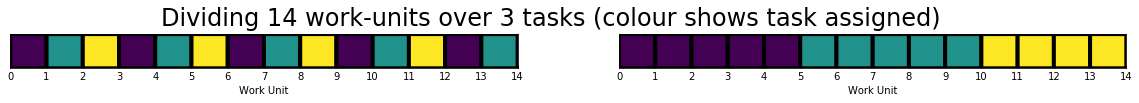

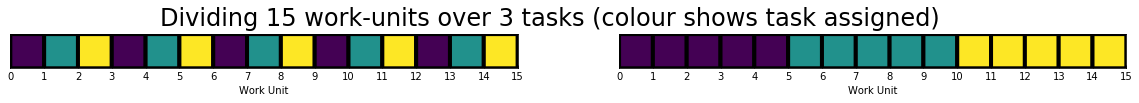

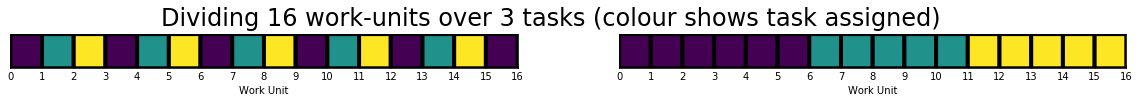

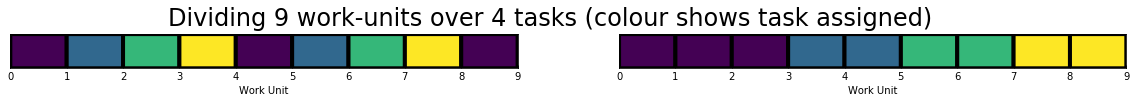

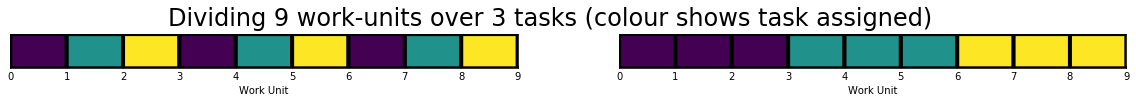

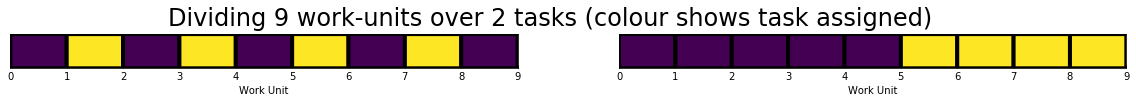

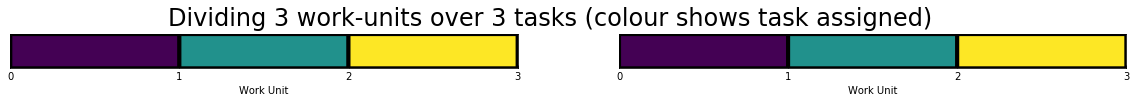

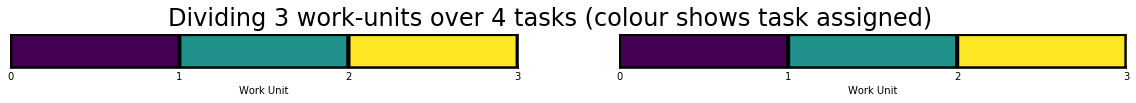

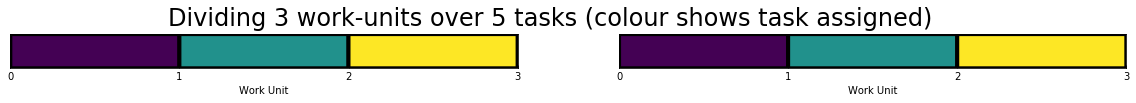

In [11]:
nwork_and_ntasks = [(14, 3), (15, 3), (16, 3), 
                     (9, 4),  (9, 3),  (9, 2), 
                     (3, 3),  (3, 4),  (3, 5)]

partition_types = [1, 2]
ncols = len(partition_types)
figheight = 1.0
figsize=(20.0 * figheight, figheight)
for nw, nt in nwork_and_ntasks:
    fig, axes = plt.subplots(1, ncols, figsize=figsize)
    fig.subplots_adjust(top=0.6)
    fig.suptitle(f"Dividing {nw} work-units over {nt} tasks (colour shows task assigned)", fontsize=24)
    
    for ptype, ax in zip(partition_types, axes):
        assigned_tasks = assign_partition(nw, nt, partition_type=ptype, pretty_print=False)
        discrete_matshow(assigned_tasks, ax=ax)



<hr style="border:2px solid gray"> </hr>

## Using `mpi4py` for distributed computing

The `mpi4py` package makes it very easy to write distributed code. There are a variety of examples in the [mpi4py tutorial](https://mpi4py.readthedocs.io/en/stable/tutorial.html) to show how `mpi4py` works. 

Every MPI spawned process has a "communicator" associated with it. We will exclusively use the "global" communicator, `MPI.COMM_WORLD` to figure out:

1. How many tasks (`ntasks`) are in this computation  -- `MPI.COMM_WORLD.Get_rank()`
2. An unique ID (`rank`) to identify each task -- `MPI.COMM_WORLD.Get_size()`


<hr style="border:2px solid gray"> </hr>

## Where is the output produced

We are going to take a shortcut and assume there is no explicit output returned by the ``processing_function``. You can easily mimic this by creating an unique output file per MPI task and appending all results (from that task) into the unique file. For instance, you could create a file called `results_<rank>.txt` and then append a newline containing the `(filename, results)` for every processed `filename`.

In [12]:
def your_custom_processing_func(input_fname, rank=0, outputfilebase='results'):
    numlines = None
    try:
        with open(input_fname, 'r') as f:
            numlines = 0
            for line in f:
                numlines += 1
    except IOError:
        print(f"[Rank={rank}]: Did not find input file = '{input_fname}'")
        pass

    # Now write the reusult
    outputfilename=f"{outputfilebase}_{rank}.csv"
    with open(outputfilename, 'a') as f:
        f.write(f"{input_fname}, {numlines}\n")

    return      

In [13]:
def distributed_processing(filenames, processing_func=None, outputfilebase='results'):
    import sys
    import time
    
    rank = 0
    ntasks = 1
    MPI = None
    comm = None
    try:
        from mpi4py import MPI
        comm = MPI.COMM_WORLD
        rank = comm.Get_rank()
        ntasks = comm.Get_size()
    except ImportError:
        pass
    
    # Protect against the case where a single
    # file was passsed
    if not isinstance(filenames, (list, tuple)):
        filenames = [filenames]
        
    sys.stdout.flush()
    nfiles = len(filenames)
    if nfiles < ntasks:
        print(f"[Rank={rank}]: Nfiles = {nfiles} < total tasks = {ntasks}. "\
               "Some tasks will not have any work assigned (and will be idle)")

    tstart = time.perf_counter()
    if rank == 0:
        print(f"[Rank={rank}]: Converting nfiles = {nfiles} over ntasks = {ntasks}...")

    # Convert files in MPI parallel (if requested)
    # the range will produce filenum starting with "rank"
    # and then incrementing by "ntasks" all the way upto
    # and inclusive of [nfiles-1]. That is, the range [0, nfiles-1]
    # will be uniquely distributed over ntasks.
    for filenum in range(rank, nfiles, ntasks):  
        processing_func(filenames[filenum], rank)

    # The barrier is only essential so that the total time printed
    # out on rank==0 is correct.
    if comm:
        comm.Barrier()

    if rank == 0:
        t1 = time.perf_counter()
        print("[Rank={}]: Converting nfiles = {} over ntasks = {}...done. "\
              "Time taken = {:0.2f} seconds".format(rank, nfiles, ntasks, t1 - tstart))        
        
    return True


if __name__ == "__main__":
    print("here")
    import glob
    filenames = glob.glob("*.txt")
    distributed_processing(filenames, your_custom_processing_func)

here
[Rank=0]: Converting nfiles = 1 over ntasks = 1...
[Rank=0]: Converting nfiles = 1 over ntasks = 1...done. Time taken = 0.00 seconds


## Switch to the command-line to run MPI code

### Challenge: If you keep re-running the code, then the output file keeps getting appended to. How would you fix that?





### [Advanced] What happens if the input files have been modified?

----

<details> <summary> Recommended Practice (click to expand)</summary>
    
A couple of things to consider:

1. When was the input file last modified?
2. When did the line-counter (i.e., this code) run?
3. Is it possible that file contents have been modified without changing the number of lines?

Of course, if a file has not been modified, then there is no reason to add another line. If the file has been updated, but the number of lines has not been changed, then how do you know if the file content was altered or not?

The generic recommendation is to **always add metadata info**. For instance, in this case, you might want to consider the following (in increasing order of complexity/paranoia/thoroughness):

1. The file modification time for the input file
2. Some sort of hash for the input file contents (md5, sha, ...)
3. The date-time when the line-counter program was run
4. A git sha identifying the source commit, or a hash of the entire source code if there are outstanding changes


</details>

----



## Running parallel code within Jupyter notebooks 

Can be done but takes a bit of setup. I followed the instructions [here](https://charlesreid1.com/wiki/Jupyter/MPI) to setup `ipyparallel` and then run the following chunk of code

In [15]:
from ipyparallel import Client
from mpi4py import MPI

c = Client(profile='mpi')
view = c[:]

print("Client MPI.COMM_WORLD.Get_size()=%s" % MPI.COMM_WORLD.Get_size())
print("Client engine ids %s" % c.ids)

def _get_rank():
    from mpi4py import MPI
    return MPI.COMM_WORLD.Get_rank()

def _get_size():
    from mpi4py import MPI
    return MPI.COMM_WORLD.Get_size()

print("Remote COMM_WORLD ranks %s" % view.apply_sync(_get_rank))
print("Remote COMM_WORLD size %s" % view.apply_sync(_get_size))

Client MPI.COMM_WORLD.Get_size()=1
Client engine ids [0, 1]
Remote COMM_WORLD ranks [0, 1]
Remote COMM_WORLD size [2, 2]
